In [1]:
# --- Non-Gaussian comparisons, matching 03_simulations style (prefix-based) ---

from pathlib import Path
import re, pandas as pd, numpy as np
import matplotlib.pyplot as plt

# 1) Locate results/tables robustly (no dependence on cwd)
CANDIDATES = [Path("results/tables"), Path("../results/tables"), Path("../../results/tables")]
TABLES = next((d for d in CANDIDATES if d.exists()), None)
if TABLES is None:
    raise FileNotFoundError("Couldn't find results/tables. Open the notebook in the repo or set TABLES manually.")

def latest_csv(prefix: str) -> Path:
    """Pick the most recent file by name for a given prefix (e.g., 't_p250_', 'laplace_p250_')."""
    files = sorted(TABLES.glob(f"{prefix}*.csv"))
    if not files:
        raise FileNotFoundError(f"No CSVs matching {prefix}*.csv in {TABLES}")
    return files[-1]

def mean_se(series: pd.Series):
    """Return (mean, se)."""
    m = series.mean()
    se = series.std(ddof=1) / max(len(series)**0.5, 1)
    return m, se

def pick_cols(df: pd.DataFrame, kind="fdr", alpha="0.05"):
    """
    Collect columns for a given metric kind ('fdr' or 'power') at alpha,
    mapping to nice labels. Works whether LCT-B B settings are present or not.
    """
    cols = [c for c in df.columns if c.startswith(f"{kind}_") and f"_{alpha}" in c]
    # stable method ordering for readability
    order = []
    # BH/BY
    order += [c for c in cols if c.startswith(f"{kind}_bh_")]
    order += [c for c in cols if c.startswith(f"{kind}_by_")]
    # LCT-N
    order += [c for c in cols if re.match(fr"^{kind}_lct_{alpha}$", c)]
    # LCT-B with B
    order += sorted([c for c in cols if re.match(fr"^{kind}_lctb_{alpha}_B\d+$", c)],
                    key=lambda x: int(re.search(r"_B(\d+)$", x).group(1)))
    # Fallback: any other columns not captured
    order += [c for c in cols if c not in order]
    # Nice labels
    labels = []
    for c in order:
        if c.startswith(f"{kind}_bh_"): labels.append("BH")
        elif c.startswith(f"{kind}_by_"): labels.append("BY")
        elif c == f"{kind}_lct_{alpha}": labels.append("LCT-N")
        elif c.startswith(f"{kind}_lctb_{alpha}_B"):
            B = re.search(r"_B(\d+)$", c).group(1)
            labels.append(f"LCT-B B={B}")
        else:
            labels.append(c)
    return order, labels

def plot_method_bars(df: pd.DataFrame, title: str, save_png: str | None = None, alpha="0.05"):
    """
    Make side-by-side bar charts for FDR and Power (mean ± SE) at a given alpha.
    Uses only columns present in the DataFrame.
    """
    fdr_cols, fdr_labels = pick_cols(df, kind="fdr", alpha=alpha)
    pwr_cols, pwr_labels = pick_cols(df, kind="power", alpha=alpha)

    # Compute means/SEs
    def stats_for(cols):
        means, ses = [], []
        for c in cols:
            m, se = mean_se(df[c])
            means.append(m); ses.append(se)
        return np.array(means), np.array(ses)

    fdr_means, fdr_ses = stats_for(fdr_cols) if fdr_cols else (np.array([]), np.array([]))
    pwr_means, pwr_ses = stats_for(pwr_cols) if pwr_cols else (np.array([]), np.array([]))

    # Plot
    nrows = 1 if (len(fdr_cols)==0 or len(pwr_cols)==0) else 2
    plt.figure(figsize=(9, 3.6*nrows))

    idx = 1
    if len(fdr_cols):
        plt.subplot(nrows, 1, idx); idx += 1
        plt.bar(range(len(fdr_means)), fdr_means, yerr=fdr_ses)
        plt.xticks(range(len(fdr_means)), fdr_labels, rotation=20, ha="right")
        plt.ylabel("FDR"); plt.ylim(0, max(0.05, float(fdr_means.max()*1.2)))
        plt.title(f"{title} — FDR @ α={alpha}")

    if len(pwr_cols):
        plt.subplot(nrows, 1, idx)
        plt.bar(range(len(pwr_means)), pwr_means, yerr=pwr_ses)
        plt.xticks(range(len(pwr_means)), pwr_labels, rotation=20, ha="right")
        plt.ylabel("Power"); plt.ylim(0, min(1.0, float(max(0.05, pwr_means.max()*1.2))))
        plt.title(f"{title} — Power @ α={alpha}")

    plt.tight_layout()
    if save_png:
        plt.savefig(TABLES.parent / save_png, dpi=160, bbox_inches="tight")
    plt.show()

Using: gaussian_p250_n80_80_rho0.3_b20_R50.csv | gaussian_p500_n80_80_rho0.25_b20_R50.csv


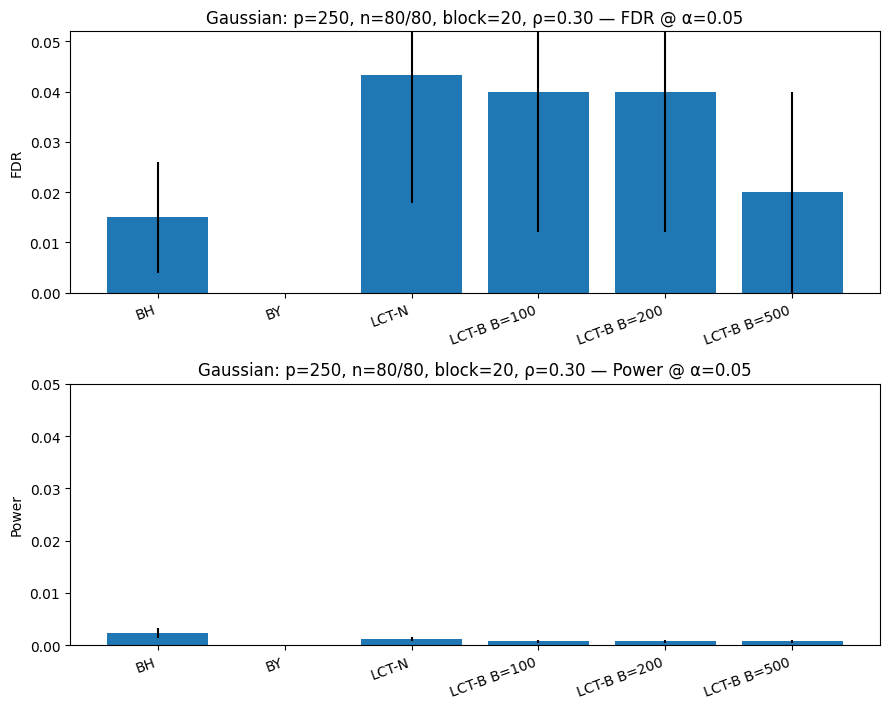

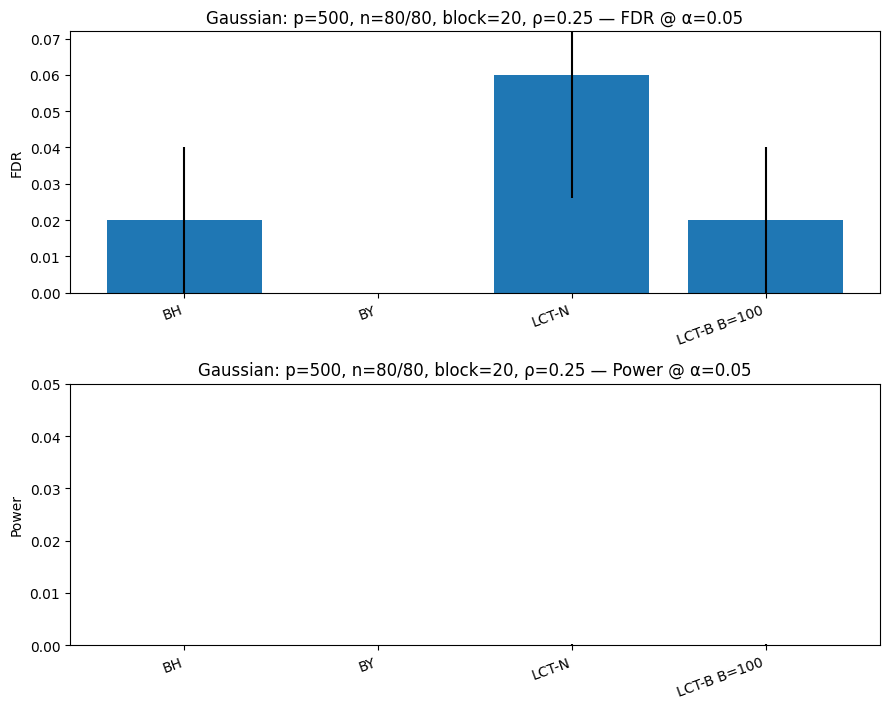

Using: t_p250_n80_80_rho0.3_b20_R50_df6.csv


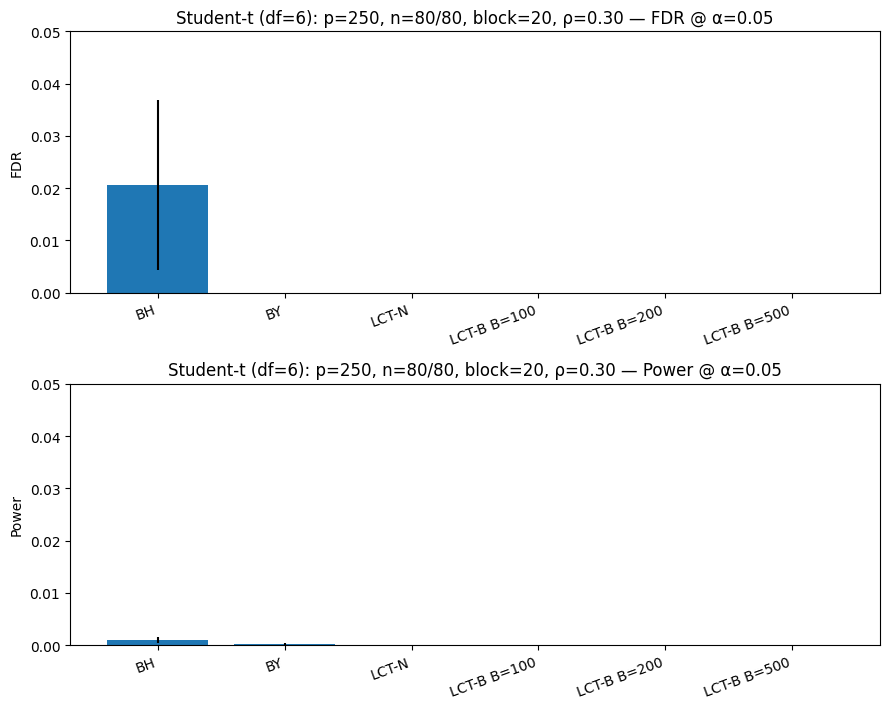

Using: laplace_p250_n80_80_rho0.3_b20_R50_b0.7071067811865475.csv


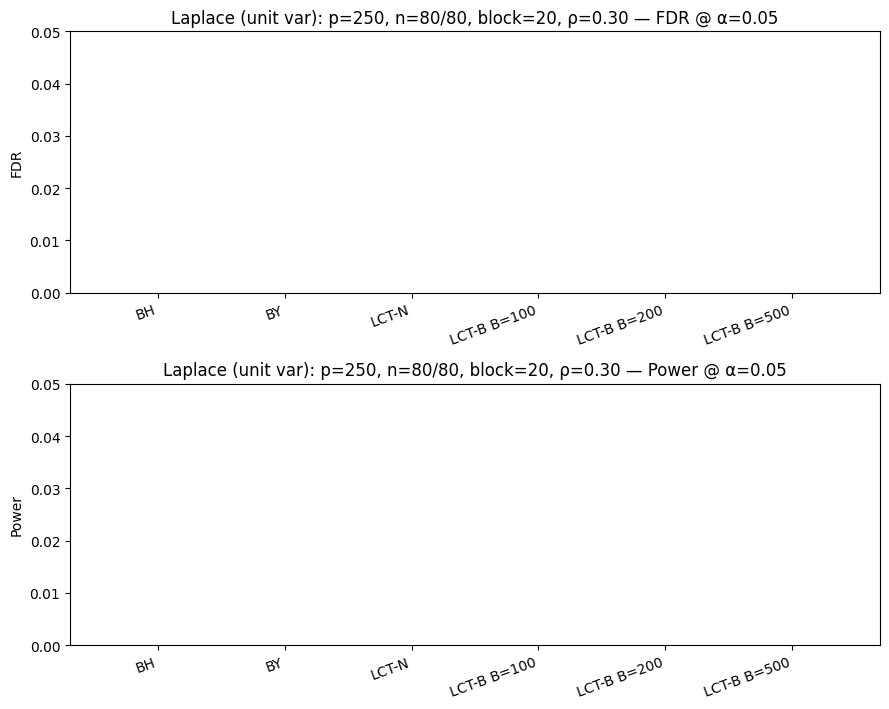

Using: exp_p250_n80_80_rho0.3_b20_R50_rate1.0.csv


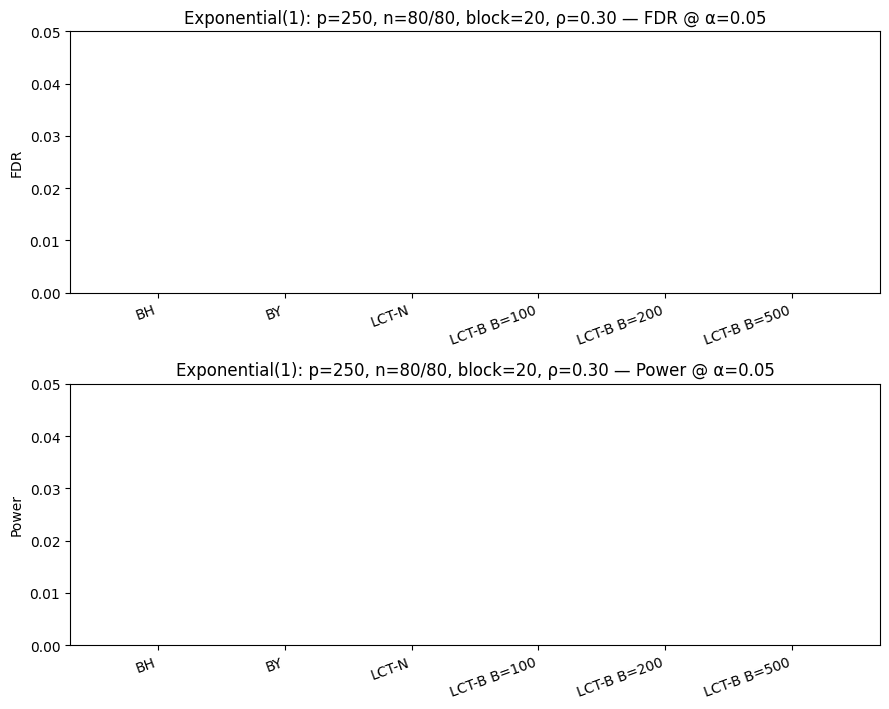

In [2]:
# --- Load latest CSVs for each setting and plot ---

# Gaussian (you already have these)
csv_g250 = latest_csv("gaussian_p250_")
csv_g500 = latest_csv("gaussian_p500_")
df_g250  = pd.read_csv(csv_g250)
df_g500  = pd.read_csv(csv_g500)
print("Using:", csv_g250.name, "|", csv_g500.name)

plot_method_bars(df_g250, "Gaussian: p=250, n=80/80, block=20, ρ=0.30", "gaussian_p250_alpha005.png", alpha="0.05")
plot_method_bars(df_g500, "Gaussian: p=500, n=80/80, block=20, ρ=0.25", "gaussian_p500_alpha005.png", alpha="0.05")

# Non-Gaussian (run quick sims first if files aren't there)
# t(df=6)
try:
    csv_t250 = latest_csv("t_p250_")
    df_t250  = pd.read_csv(csv_t250)
    print("Using:", csv_t250.name)
    plot_method_bars(df_t250, "Student-t (df=6): p=250, n=80/80, block=20, ρ=0.30", "t_p250_alpha005.png", alpha="0.05")
except FileNotFoundError as e:
    print("Skip t p=250:", e)

# Laplace (b=1/sqrt(2))
try:
    csv_lap250 = latest_csv("laplace_p250_")
    df_lap250  = pd.read_csv(csv_lap250)
    print("Using:", csv_lap250.name)
    plot_method_bars(df_lap250, "Laplace (unit var): p=250, n=80/80, block=20, ρ=0.30", "laplace_p250_alpha005.png", alpha="0.05")
except FileNotFoundError as e:
    print("Skip Laplace p=250:", e)

# Exponential(1), centered & z-scored
try:
    csv_exp250 = latest_csv("exp_p250_")
    df_exp250  = pd.read_csv(csv_exp250)
    print("Using:", csv_exp250.name)
    plot_method_bars(df_exp250, "Exponential(1): p=250, n=80/80, block=20, ρ=0.30", "exp_p250_alpha005.png", alpha="0.05")
except FileNotFoundError as e:
    print("Skip Exp p=250:", e)